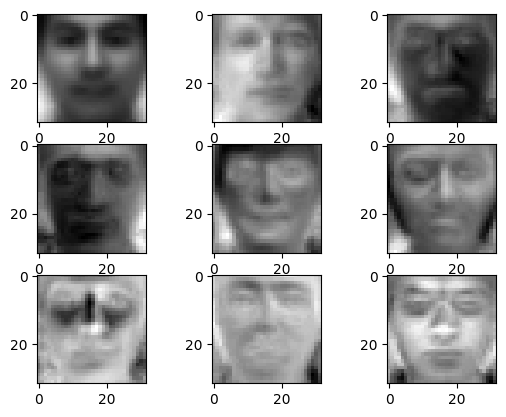

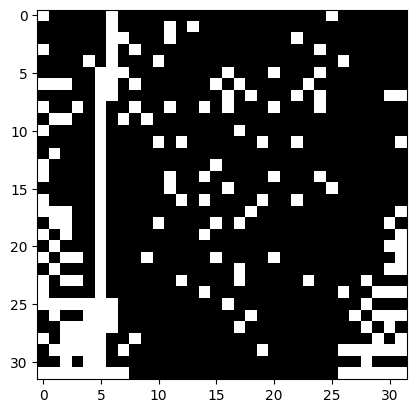

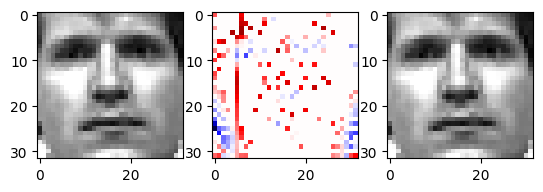

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import scipy.linalg
import scipy.optimize
#Loading data
mat = scipy.io.loadmat('./data/Yale_32x32.mat')
X = mat['fea'].T
n_POD_components = 200
# Number of sensors has to be larger or equal to the number of POD components
n_sensors = 200
# Function for finding first n POD components using svd
def calculate_POD(X, n, mean_centering=True):
    if mean_centering:
        X_mean = np.mean(X, axis=1, keepdims=True) 
        X_ = X - np.tile(X_mean,(1,X.shape[1]))
    else:
        X_ = X
        X_mean = np.zeros((X.shape[0],1))
    U, S, V = np.linalg.svd(X_)
    Psi_r = U[:,:n]
       
    return Psi_r, X_mean
# Finding POD basis (Psi_r)
Psi_r, X_mean  = calculate_POD(X, n_POD_components)

# Showing the mean and the first 10 POD components
plt.subplot(3,3,1)
plt.imshow(X_mean.reshape(32,32).T, cmap="gray")
for i in range(8):
    plt.subplot(3,3, i+2)
    plt.imshow(Psi_r[:,i].reshape(32,32).T, cmap="gray")
plt.show()

# Functions for finding optimal sensor placement 
def qr_pivots(Psi_r, num_eigen, num_sensors=None):
    if num_sensors is None:
        num_sensors = num_eigen
    
    M = Psi_r.T
    if num_sensors > num_eigen:
        M = Psi_r @  Psi_r.T

    Q, R, P = scipy.linalg.qr(M, pivoting=True)
    return P

def find_sensor_placement_QR(Psi_r, num_eigen, num_sensors=None):
    P = qr_pivots(Psi_r, num_eigen, num_sensors)
    C = np.zeros((num_sensors,Psi_r.shape[0]))
    C[np.arange(num_sensors),P[:num_sensors]] = 1
    return C

# Finding the sensor placement matrix C
C = find_sensor_placement_QR(Psi_r, n_POD_components, n_sensors)

plt.imshow(np.sum(C, axis=0).reshape(32,32).T, cmap='gray')
plt.show()

Theta = C @ Psi_r
Theta_inv = np.linalg.pinv(Theta)

def create_measurements_sensor_placement(X, C, X_mean):
    Y = np.dot(C, (X - np.tile(X_mean,(1,X.shape[1]))))
    return Y

Y = create_measurements_sensor_placement(X, C, X_mean)

def reconstruct_from_measurements(Y, C, Psi_r, X_mean,Theta_inv = None):
    if Theta_inv is None:
        Theta_inv = np.linalg.inv(np.dot(C, Psi_r))
    X_hat = np.dot(Psi_r, np.dot(Theta_inv, Y)) + np.tile(X_mean,(1,Y.shape[1]))
    return X_hat
X_hat = reconstruct_from_measurements(Y, C, Psi_r, X_mean, Theta_inv)
# Show image measurement and reconstruction of face image
image_index = np.random.choice(X.shape[1])
plt.subplot(1,3,1)
plt.imshow(X[:,image_index].reshape(32,32).T, cmap="gray")
plt.subplot(1,3,2)
y_image = (Y[:,image_index]*C.T).T.sum(axis=0).reshape(32,32).T
y_max = np.max(np.abs(y_image))
plt.imshow(y_image, cmap="seismic", vmin=-y_max, vmax=y_max)
plt.subplot(1,3,3)
plt.imshow(X_hat[:,image_index].reshape(32,32).T, cmap="gray")

plt.show()

# From compressed sensing to optimal sensor placement

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.linalg
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.metrics import mean_squared_error


We use the Yale Faces dataset (32×32 resolution).  

- Each face has **1024 pixels**.  
- The dataset matrix `X` has shape `(1024, num_images)`.  
- We’ll compare reconstructions using **random sensors (Compressed Sensing)** vs **QR-selected sensors (Optimal Sensor Placement)**.


Data shape: (1024, 165)


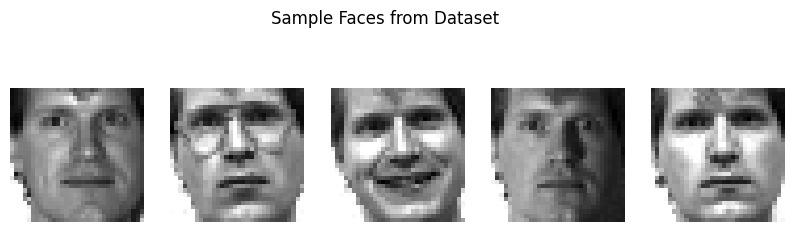

In [27]:
# Load dataset
mat = scipy.io.loadmat('./data/Yale_32x32.mat')
X = mat['fea'].T  # shape: (1024, num_images)
print("Data shape:", X.shape)

# Show a few faces
plt.figure(figsize=(10,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X[:,i].reshape(32,32).T, cmap="gray")
    plt.axis("off")
plt.suptitle("Sample Faces from Dataset")
plt.show()


POD (similar to PCA) finds the **dominant modes (eigenfaces)** of variation across all images.  

- Each face can be approximated as a linear combination of a few POD modes.  
- This gives us a **low-rank representation** of the dataset.  


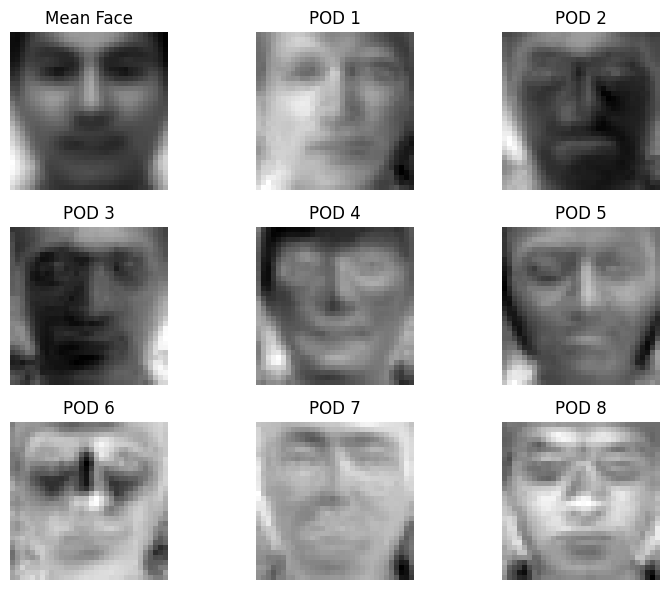

In [28]:
def calculate_POD(X, n, mean_centering=True):
    if mean_centering:
        X_mean = np.mean(X, axis=1, keepdims=True)
        X_ = X - X_mean
    else:
        X_ = X
        X_mean = np.zeros((X.shape[0],1))
    U, S, V = np.linalg.svd(X_, full_matrices=False)
    Psi_r = U[:, :n]
    return Psi_r, X_mean

n_POD_components = 50
Psi_r, X_mean = calculate_POD(X, n_POD_components)

# Show mean + first 8 POD modes
plt.figure(figsize=(8,6))
plt.subplot(3,3,1)
plt.imshow(X_mean.reshape(32,32).T, cmap="gray")
plt.title("Mean Face")
plt.axis("off")
for i in range(8):
    plt.subplot(3,3,i+2)
    plt.imshow(Psi_r[:,i].reshape(32,32).T, cmap="gray")
    plt.title(f"POD {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In **Compressed Sensing (CS)**:  
- We pick **random sensor pixels**.  
- Measure only those pixel values.  
- Reconstruct using **sparsity assumption** in the POD basis + OMP (Orthogonal Matching Pursuit).  

This is **data-agnostic**: we don’t use knowledge of which pixels matter most.  


c:\pinokio\bin\miniconda\envs\ham\Lib\site-packages\sklearn\linear_model\_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


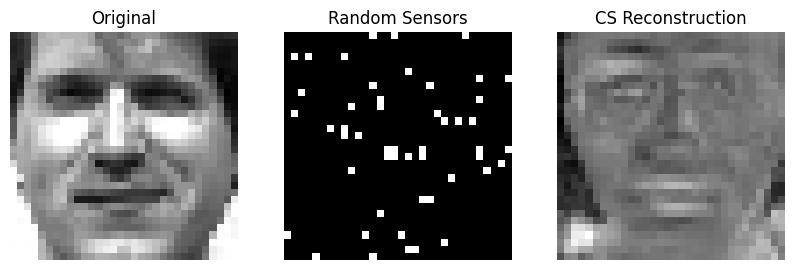

In [29]:
def cs_reconstruction(X, Psi_r, X_mean, n_sensors, img_index):
    n = X.shape[0]
    rand_idx = np.random.choice(n, n_sensors, replace=False)
    C_rand = np.zeros((n_sensors, n))
    C_rand[np.arange(n_sensors), rand_idx] = 1

    # Measurement
    y_rand = C_rand @ (X[:,img_index] - X_mean.flatten())

    # Reconstruction with OMP
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_POD_components)
    omp.fit(C_rand @ Psi_r, y_rand)
    coeffs = omp.coef_
    X_hat = Psi_r @ coeffs + X_mean.flatten()
    return X_hat, C_rand

# Example
img_index = 10
X_hat_cs, C_rand = cs_reconstruction(X, Psi_r, X_mean, n_sensors=50, img_index=img_index)

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(X[:,img_index].reshape(32,32).T, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
mask = np.sum(C_rand, axis=0).reshape(32,32).T
plt.imshow(mask, cmap="gray")
plt.title("Random Sensors")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(X_hat_cs.reshape(32,32).T, cmap="gray")
plt.title("CS Reconstruction")
plt.axis("off")
plt.show()


Instead of random sensors, we can **choose the most informative pixels**.  

- Use **QR decomposition with pivoting** on the POD basis.  
- Selects sensor locations where the POD modes are most independent.  
- Reconstruction becomes stable and more accurate.  


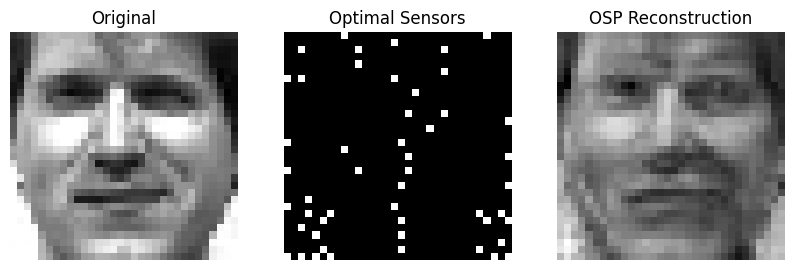

In [30]:
def qr_pivots(Psi_r, num_eigen, num_sensors=None):
    if num_sensors is None:
        num_sensors = num_eigen
    M = Psi_r.T
    if num_sensors > num_eigen:
        M = Psi_r @ Psi_r.T
    Q, R, P = scipy.linalg.qr(M, pivoting=True)
    return P

def find_sensor_placement_QR(Psi_r, num_eigen, num_sensors=None):
    P = qr_pivots(Psi_r, num_eigen, num_sensors)
    C = np.zeros((num_sensors, Psi_r.shape[0]))
    C[np.arange(num_sensors), P[:num_sensors]] = 1
    return C

def osp_reconstruction(X, Psi_r, X_mean, n_sensors, img_index):
    C = find_sensor_placement_QR(Psi_r, n_POD_components, n_sensors)
    Theta = C @ Psi_r
    Theta_inv = np.linalg.pinv(Theta)
    Y = C @ (X - X_mean)
    X_hat = Psi_r @ (Theta_inv @ Y[:,img_index]) + X_mean.flatten()
    return X_hat, C

# Example
X_hat_opt, C_opt = osp_reconstruction(X, Psi_r, X_mean, n_sensors=50, img_index=img_index)

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(X[:,img_index].reshape(32,32).T, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
mask = np.sum(C_opt, axis=0).reshape(32,32).T
plt.imshow(mask, cmap="gray")
plt.title("Optimal Sensors")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(X_hat_opt.reshape(32,32).T, cmap="gray")
plt.title("OSP Reconstruction")
plt.axis("off")
plt.show()


Now we compare:  
- **Original Face**  
- **CS Reconstruction (Random Sensors)**  
- **OSP Reconstruction (QR-selected Sensors)**  


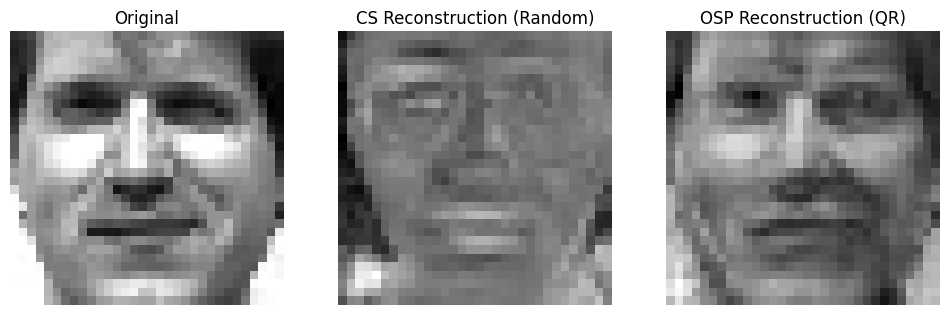

In [31]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(X[:,img_index].reshape(32,32).T, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(X_hat_cs.reshape(32,32).T, cmap="gray")
plt.title("CS Reconstruction (Random)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(X_hat_opt.reshape(32,32).T, cmap="gray")
plt.title("OSP Reconstruction (QR)")
plt.axis("off")
plt.show()
